# Project: Toyota Corolla 중고차 가격 예측

In [79]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import scipy as sp
import matplotlib.pyplot as plt
from patsy import dmatrix

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 분석대상 Data 가져오기

In [22]:
#내꺼
test = pd.read_csv("../project1/dss-regression-datasets/project-toyotacorolla-data/test.csv")
df = pd.read_csv("../project1/dss-regression-datasets/project-toyotacorolla-data/train.csv")

In [23]:
#test = pd.read_csv("test.csv") # 회귀모델 결정 후 예측의 대상이 되는 data 
#df = pd.read_csv("train.csv") # train dataset (cross validation을 위해 나눌 것. 비율은? )
#var_desc = pd.read_excel("data_description.xls") # 독립변수에 대한 간단한 설명

## 데이터 살펴보기

In [24]:
df.tail(2)

,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,...,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Parking_Assistant,Tow_Bar
1017,1441,TOYOTA Corolla 1.3 16V HATCHB LINEA TERRA 2/3-...,7250,70,11,1998,16916,Petrol,86,1,...,0,0,0,0,0,1,0,0,0,0
1018,1442,TOYOTA Corolla 1.6 LB LINEA TERRA 4/5-Doors,6950,76,5,1998,1,Petrol,110,0,...,0,1,0,0,0,0,0,0,0,0


In [25]:
# 확인해보니 데이터셋에 NaN 값은 없음. Model, Fuel_Type, Color은 문자열값
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1019 entries, 0 to 1018
Data columns (total 39 columns):
Id                   1019 non-null int64
Model                1019 non-null object
Price                1019 non-null int64
Age_08_04            1019 non-null int64
Mfg_Month            1019 non-null int64
Mfg_Year             1019 non-null int64
KM                   1019 non-null int64
Fuel_Type            1019 non-null object
HP                   1019 non-null int64
Met_Color            1019 non-null int64
Color                1019 non-null object
Automatic            1019 non-null int64
CC                   1019 non-null int64
Doors                1019 non-null int64
Cylinders            1019 non-null int64
Gears                1019 non-null int64
Quarterly_Tax        1019 non-null int64
Weight               1019 non-null int64
Mfr_Guarantee        1019 non-null int64
BOVAG_Guarantee      1019 non-null int64
Guarantee_Period     1019 non-null int64
ABS                  1019 non

In [26]:
#기술통계량 확인
print(df.describe())

                Id         Price    Age_08_04    Mfg_Month     Mfg_Year  \
count  1019.000000   1019.000000  1019.000000  1019.000000  1019.000000   
mean    724.867517  10738.358194    56.041217     5.480864  1999.623160   
std     415.043138   3614.987568    18.615283     3.304515     1.548589   
min       1.000000   4350.000000     1.000000     1.000000  1998.000000   
25%     363.000000   8400.000000    44.000000     3.000000  1998.000000   
50%     732.000000   9850.000000    61.000000     5.000000  1999.000000   
75%    1081.500000  11950.000000    70.000000     8.000000  2001.000000   
max    1442.000000  31000.000000    80.000000    12.000000  2004.000000   

                  KM           HP    Met_Color    Automatic            CC  \
count    1019.000000  1019.000000  1019.000000  1019.000000   1019.000000   
mean    68177.927380   101.479882     0.669284     0.056919   1579.582924   
std     37966.031948    14.811333     0.470702     0.231801    488.566949   
min         1.00

In [27]:
dfy = df.iloc[:, :3]
dfX = df.iloc[:, 3:]
print(dfy.columns)
print(dfX.columns)

Index(['Id', 'Model', 'Price'], dtype='object')
Index(['Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM', 'Fuel_Type', 'HP',
       'Met_Color', 'Color', 'Automatic', 'CC', 'Doors', 'Cylinders', 'Gears',
       'Quarterly_Tax', 'Weight', 'Mfr_Guarantee', 'BOVAG_Guarantee',
       'Guarantee_Period', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco',
       'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock',
       'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps',
       'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette',
       'Parking_Assistant', 'Tow_Bar'],
      dtype='object')


## EDA (Exploratory Data Analysis)

    1) 독립변수들 중 연속확률변수 항목:
       'Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM', 'HP', 'CC', 'Doors', 'Cylinders', 'Gears',
       'Quarterly_Tax', 'Weight', 'Guarantee_Period'
    
    2) 독립변수들 중 카테고리변수 항목: 1)의 연속확률변수들을 제외한 나머지 변수들
    
       'Fuel_Type', 'Met_Color', 'Color', 'Automatic', 'Mfr_Guarantee', 'BOVAG_Guarantee', 'ABS', 'Airbag_1',
       'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock', 'Powered_Windows', 
       'Power_Steering', 'Radio', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette', 
       'Parking_Assistant', 'Tow_Bar'

In [28]:
variables = list(dfX.columns)
var_real = ['Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM', 'HP', 'CC', 'Doors', 'Cylinders', 'Gears',
       'Quarterly_Tax', 'Weight', 'Guarantee_Period']
var_cat = []
for var in variables:
    if var not in var_real:
        var_cat.append(var)
print(len(var_real))
print(len(var_cat))
print(var_cat)

12
24
['Fuel_Type', 'Met_Color', 'Color', 'Automatic', 'Mfr_Guarantee', 'BOVAG_Guarantee', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock', 'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette', 'Parking_Assistant', 'Tow_Bar']


In [29]:
sns.pairplot(pd.concat([dfy['Price'], dfX[var_real[0:4]]], 1))

In [30]:
sns.pairplot(pd.concat([dfy['Price'], dfX[var_real[4:8]]], 1))

In [31]:
sns.pairplot(pd.concat([dfy['Price'], dfX[var_real[8:]]], 1))

## 데이터를 보고나서 생각하기

    1. 종속 변수가 Price이니 항상 양수인 값이고 샘플 데이터의 히스토그램을 봤을 때 왼쪽으로 쏠린 형태이니 log를 취해주면 정규분포에 가까워지고 특정구간(Mode 미만의 구간)이 확장되는 효과가 있을 것이다. 
    
    2. 독립변수 KM은 확실히 1/x형태의 분포를 보임. Price, Weight 둘 다 로그를 취해주고 분포를 볼 필요가 있다.
    
    3. Age_08_04는 2004년 8월 시점에서 해당 자동차의 Age를 개월수로 나타낸 것이다. 그렇다면 이를 기준으로 제조년, 제조월은 역산할 수 있는 
    값이다.따라서 Age_08_04, Mfg_Year, Mfg_Month 중에서는 한 가지 변수만 선택하면 되지 않을까?
    Mfg_Year + Mfg_Month/12는 Age_08_04와 동일한 변수가 될 것 같다.
    
    4. Cylinder의 경우는 모든 데이터셋에서 4기통으로 되어 있으니 분포가 없는 데이터이므로 변수에서 제외

    5. Model 변수(256가지)에는 다른 변수에 있는 정보가 문자열 형태로 중복되서 표현되어 있음. Doors, CC, Sport 등... 
    하지만 다른 변수들에 담겨있지 않은 정보도 있다. 이런 정보들을 추출해서 변수로 활용할 것인가 말것인가? 
    우선 model은 독립변수에서 제외하고 회귀분석을 진행해본 후 쓸만한 데이터가 없으면 추출해보자
    
    6. CC, Doors, Gears는 카테고리 변수로 봐야할 듯

    7. Cross Validation을 위해 train dataset을 어떻게 나눌가? 60:40? 80:20?
    
   
> **  => 1. Price, Weight, KM에 로그를 취해보자 **

> **  => 2. Cylinder 변수는 변수선택에서 이미 탈락이다 **

> **  => 3. Model 변수는 일단 제외하고 선형회귀를 진행해보자 **

In [32]:
#변수 구분 다시
#Cylinders는 삭제
variables.remove('Cylinders')
var_real = ['Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM', 'HP', 'Quarterly_Tax', 'Weight', 'Guarantee_Period']
var_cat = []
for var in variables:
    if var not in var_real:
        var_cat.append(var)
print(len(var_real))
print(len(var_cat))
print(var_cat)


8
27
['Fuel_Type', 'Met_Color', 'Color', 'Automatic', 'CC', 'Doors', 'Gears', 'Mfr_Guarantee', 'BOVAG_Guarantee', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock', 'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette', 'Parking_Assistant', 'Tow_Bar']


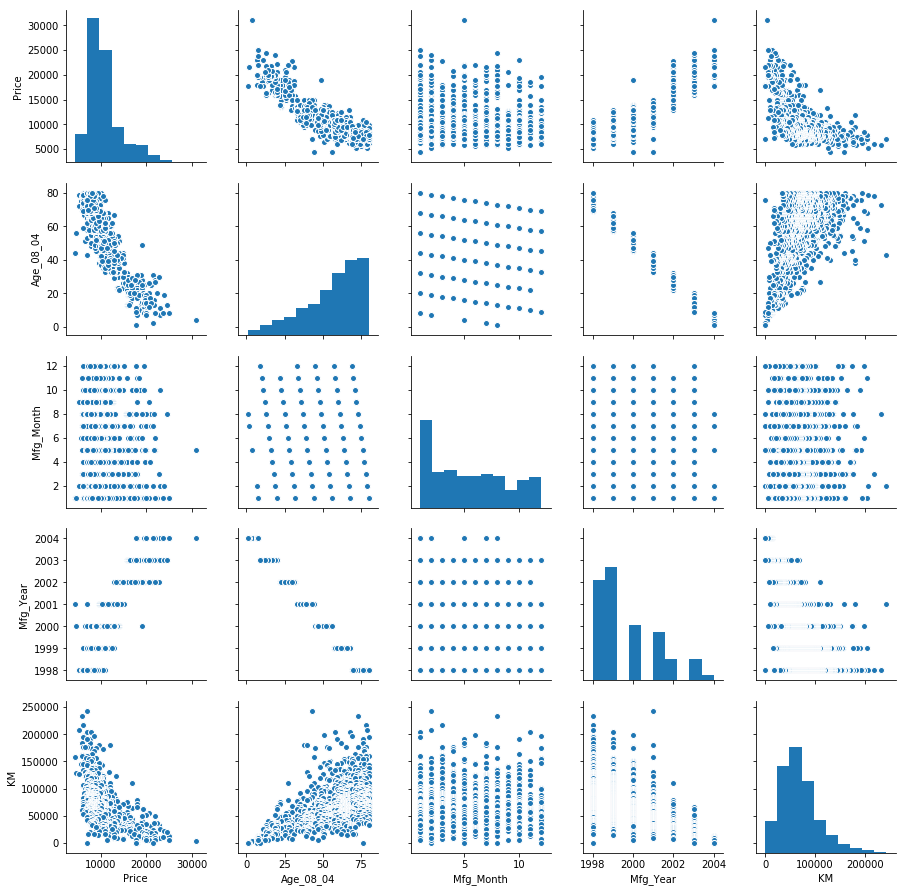

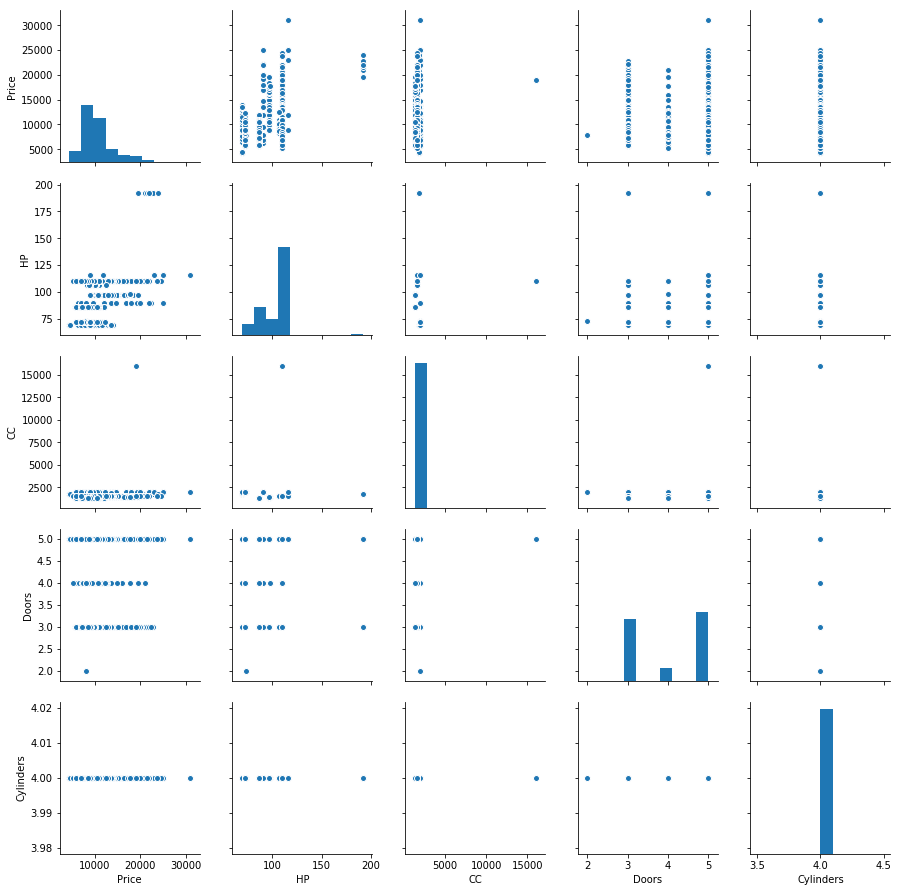

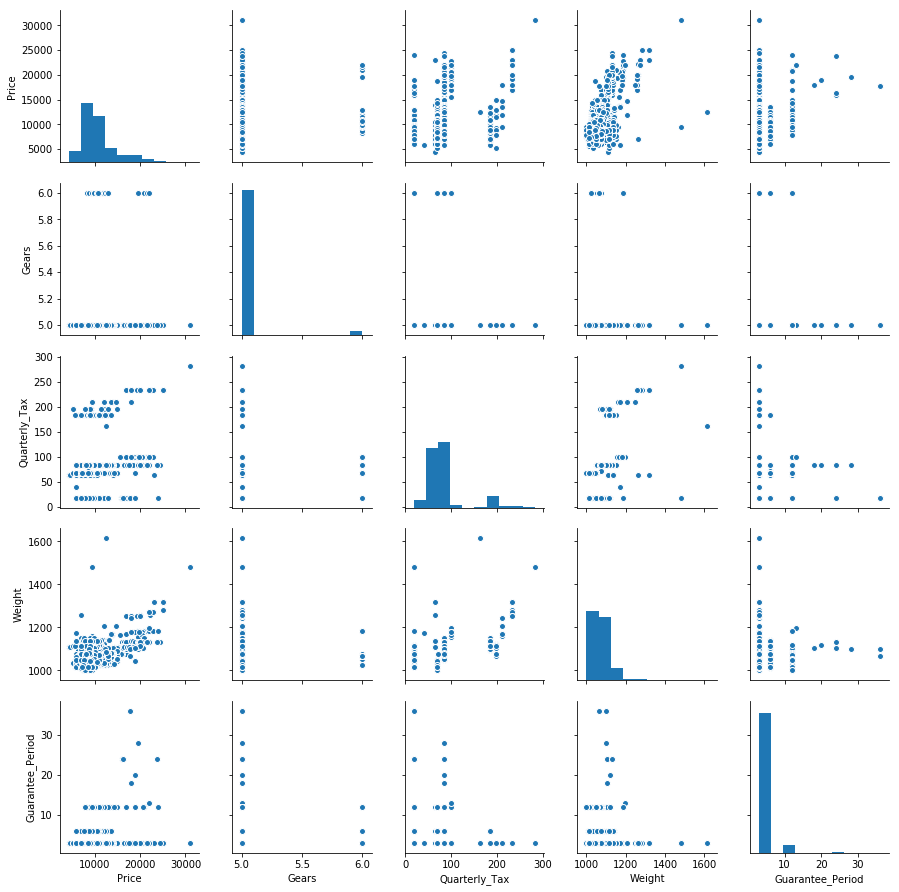

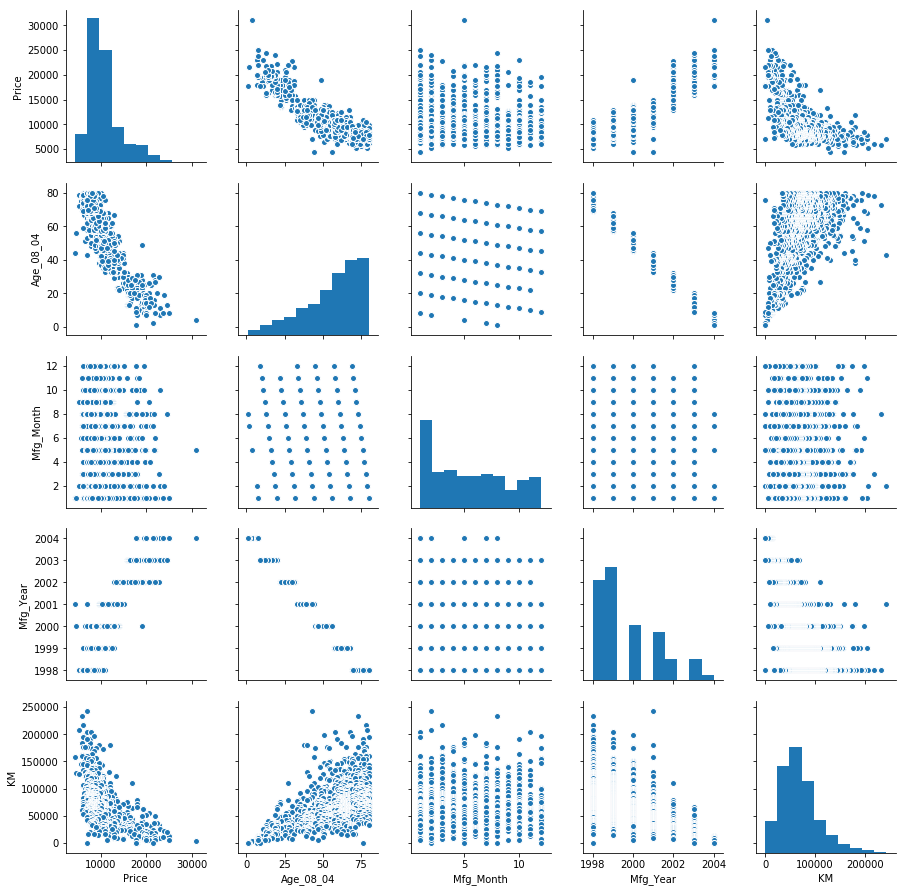

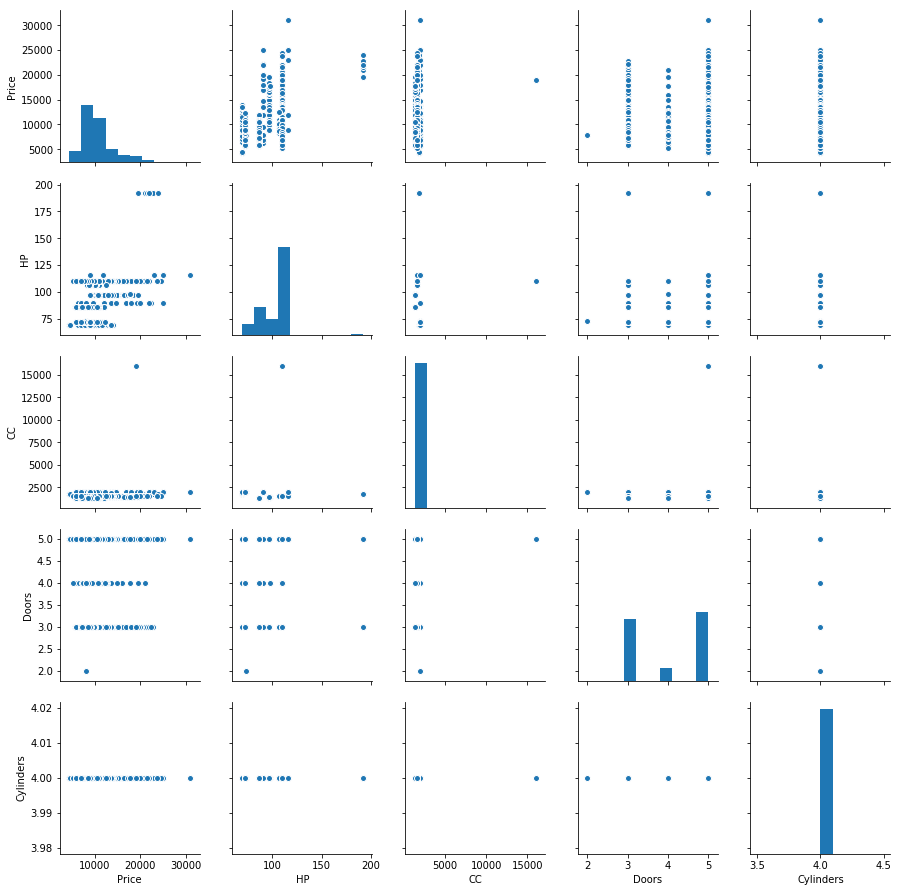

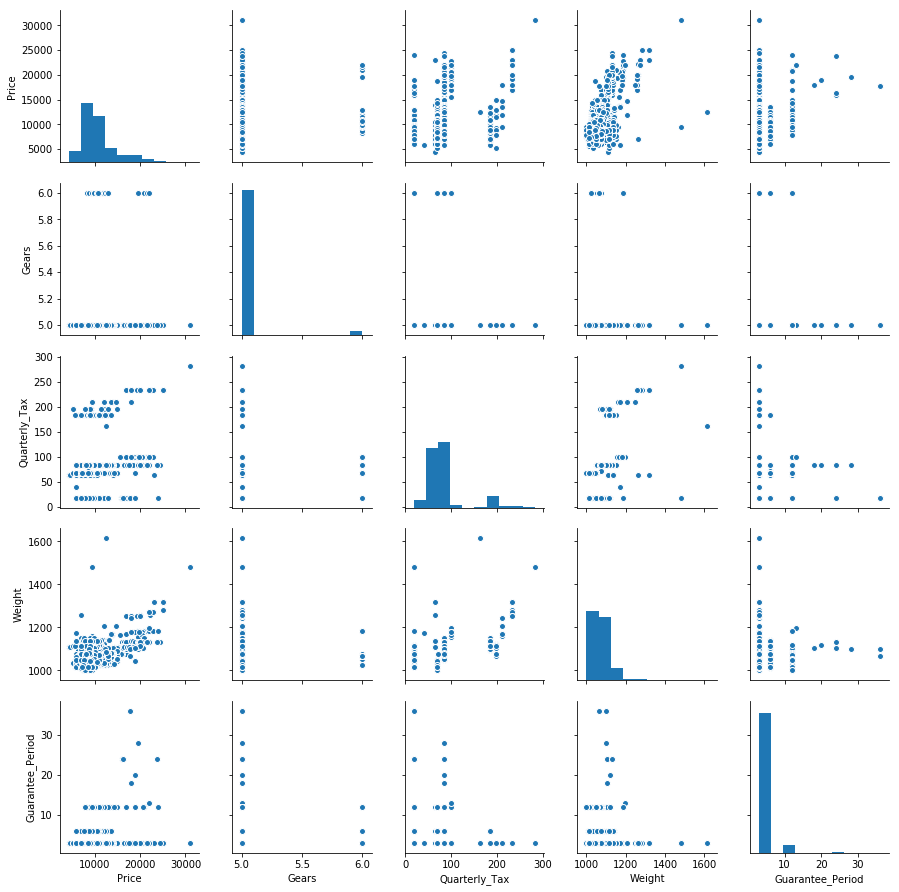

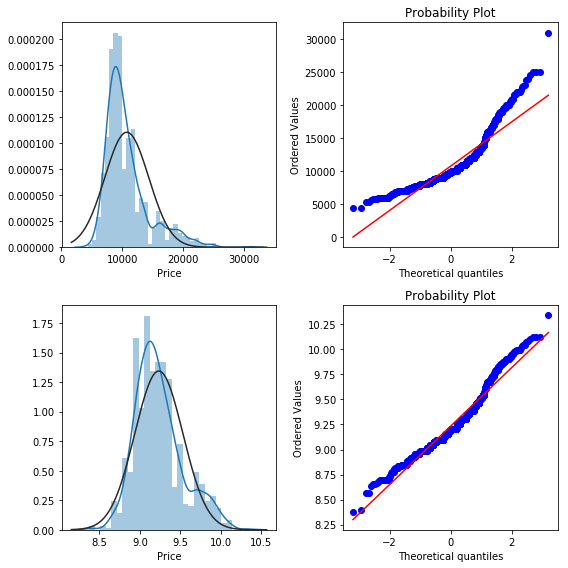

In [33]:
# Price에 로그 취하기 전후 비교: Log를 취하면 정규분포에 가까워진다
plt.figure(figsize=(8,8))
plt.subplot(221); sns.distplot(dfy['Price'], fit=sp.stats.norm);
plt.subplot(222); sp.stats.probplot(dfy['Price'], plot=plt)
plt.subplot(223); sns.distplot(np.log(dfy['Price']), fit=sp.stats.norm);
plt.subplot(224); sp.stats.probplot(np.log(dfy['Price']), plot=plt)
plt.tight_layout()
plt.show()

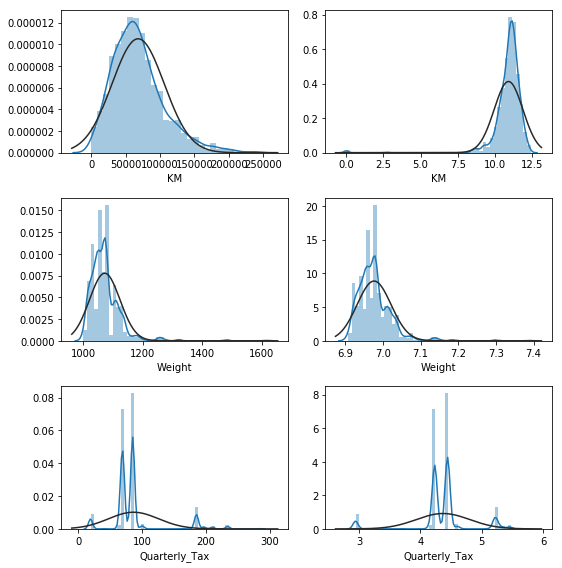

In [34]:
# KM, Weight, Quarterly_Tax에도 로그를 취한 전후 비교: Weight는 로그를 취한 결과가 더 정규분포에 가까워 보임. 
plt.figure(figsize=(8,8))
plt.subplot(321); sns.distplot(dfX['KM'], fit=sp.stats.norm); 
plt.subplot(322); sns.distplot(np.log(dfX['KM']), fit=sp.stats.norm)
plt.subplot(323); sns.distplot(df['Weight'], fit=sp.stats.norm)
plt.subplot(324); sns.distplot(np.log(df['Weight']), fit=sp.stats.norm)
plt.subplot(325); sns.distplot(df['Quarterly_Tax'], fit=sp.stats.norm)
plt.subplot(326); sns.distplot(np.log(df['Quarterly_Tax']), fit=sp.stats.norm)
plt.tight_layout()
plt.show()

    KM에 로그를 취한 분포가 왼쪽이 길게 늘어지는게 이상해서 데이터를 살펴봤더니 비정상 데이터가 보임
    CC에서 16000인 값도 발견(1600오타로 추정됨)

In [35]:
dfX.groupby('KM').groups


{1: Int64Index([83, 125, 133, 1018], dtype='int64'),
 15: Int64Index([132], dtype='int64'),
 4000: Int64Index([77], dtype='int64'),
 5000: Int64Index([124, 131], dtype='int64'),
 5278: Int64Index([123], dtype='int64'),
 5309: Int64Index([421], dtype='int64'),
 5459: Int64Index([122], dtype='int64'),
 6000: Int64Index([81, 121], dtype='int64'),
 6155: Int64Index([120], dtype='int64'),
 6250: Int64Index([130], dtype='int64'),
 6500: Int64Index([119], dtype='int64'),
 7000: Int64Index([58], dtype='int64'),
 7187: Int64Index([76], dtype='int64'),
 7650: Int64Index([118], dtype='int64'),
 8537: Int64Index([57], dtype='int64'),
 8574: Int64Index([129], dtype='int64'),
 9750: Int64Index([18], dtype='int64'),
 9788: Int64Index([128], dtype='int64'),
 10000: Int64Index([23, 80, 117, 267], dtype='int64'),
 10077: Int64Index([127], dtype='int64'),
 10210: Int64Index([420], dtype='int64'),
 10841: Int64Index([82], dtype='int64'),
 11000: Int64Index([126], dtype='int64'),
 11090: Int64Index([17], d

In [36]:
dfX.groupby('CC').groups

{1300: Int64Index([ 318,  342,  364,  377,  409,  411,  448,  453,  455,  461,
             ...
              997, 1006, 1009, 1011, 1012, 1013, 1014, 1015, 1016, 1017],
            dtype='int64', length=177),
 1332: Int64Index([589], dtype='int64'),
 1398: Int64Index([422], dtype='int64'),
 1400: Int64Index([ 18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
             ...
             406, 407, 408, 412, 413, 415, 416, 417, 419, 420],
            dtype='int64', length=114),
 1587: Int64Index([668, 964], dtype='int64'),
 1598: Int64Index([49, 117], dtype='int64'),
 1600: Int64Index([   8,    9,   10,   11,   12,   13,   14,   15,   16,   17,
             ...
             1000, 1001, 1002, 1003, 1004, 1005, 1007, 1008, 1010, 1018],
            dtype='int64', length=608),
 1800: Int64Index([3, 4, 5, 6, 7, 34, 103, 137, 280], dtype='int64'),
 1900: Int64Index([134, 138, 139, 140, 144, 145, 149, 167, 186, 187, 268, 269, 271,
             275, 277, 278, 283, 285, 287, 309, 320, 330],
    

In [37]:
#확인만 해두고 제거여부는 나중에 결정

## 상관관계 살펴보기 
    
    연속확률 변수와 카테고리 변수로 나눠서 분석

    Model, Cylinders 변수는 제거

In [38]:
print(var_real)
print(var_cat)

['Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM', 'HP', 'Quarterly_Tax', 'Weight', 'Guarantee_Period']
['Fuel_Type', 'Met_Color', 'Color', 'Automatic', 'CC', 'Doors', 'Gears', 'Mfr_Guarantee', 'BOVAG_Guarantee', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock', 'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette', 'Parking_Assistant', 'Tow_Bar']


In [39]:
df_real = pd.concat([dfy['Price'], dfX[var_real]], axis = 1)
df_cat = pd.concat([dfy['Price'], dfX[var_cat]], axis = 1)

### 종속변수와 독립변수(연속 & 이산) 상관관계  살펴보기 

   * 해당되는 변수들은 서로를 설명할 수 있는 변수라고 보고 1개만 선택
   
   * 서로 종속관계라고 볼 수 있는 독립변수는 없다고 생각된다.
   
   * 단, Price와의 상관관계가 0.2미만인 CC, Quarterly_Tax, Guarantee_Period은 변수 선택에서 제외해도 될 것이라고 판단

cor_var_real = df_real.corr()
sns.heatmap(cor_var_real, annot=True, cmap=mpl.cm.bone_r)
plt.show()

In [41]:
temp= dmatrix("Price + Age_08_04 + I(Mfg_Year + Mfg_Month/12) - 1", df_real)

In [42]:
# Age_08_04와 (Mfg_Year + Mfg_Month/12)의 상관계수 = -1
# 서로 완벽하게 설명되므로 한쪽은 사용하지 않는다. Age_08_04를 사용하기로 함. 
print(pd.DataFrame(temp).corr())
sp.stats.pearsonr(temp[1], temp[2])

        0       1       2
0  1.0000 -0.8839  0.8839
1 -0.8839  1.0000 -1.0000
2  0.8839 -1.0000  1.0000


(0.99999988800422623, 0.00030129778721698996)

In [43]:
# 이렇게 연속확률변수의 경우 Price와의 상관계수를 구했으니 이것으로 상관계수 기준을 정해 변수를 선택하면 될까?

# 상관계수도 Sample에 의존적인 확률변수(student - t 분포를 따름)
# https://en.wikipedia.org/wiki/Pearson_correlation_coefficient
# 귀무가설: 상관계수는 0이다. 상관관계가 없다
# 대립가설: 상관관계가 있다.
# => 유의확률 체크 필요
# => 양측검정

In [44]:
for var in var_real:
    print(var, sp.stats.pearsonr(df['Price'], df[var]))

Age_08_04 (-0.88389997596143111, 0.0)
Mfg_Month (-0.044254842642569896, 0.1580527380684954)
Mfg_Year (0.8933019763297112, 0.0)
KM (-0.57596185216445739, 4.2103663413920063e-91)
HP (0.31489825814758804, 6.8285036237063916e-25)
Quarterly_Tax (0.17887374583572183, 8.9566258633661347e-09)
Weight (0.55701487105264824, 4.1793981498584848e-84)
Guarantee_Period (0.16614089142820712, 9.6010919331717011e-08)


In [45]:
# Mfg_Year, Mfg_Month대신 Age_08_04를 선택
# 유의수준 0.05를 적용하면 KM, HP, Quarterly_Tax, Weight, Guarantee_Period 도 대립가설 채택되므로 변수로 선택

In [46]:
var_real = ['Age_08_04', 'KM', 'HP', 'Quarterly_Tax', 'Weight', 'Guarantee_Period']

### 종속변수와 카테고리 확률변수간의 관계
    1. 독립 표본 t-검정 (Independent-two-sample t-test): 
       클래스가 2개인 카테고리 변수의 경우 클래스에 따른 종속변수의 평균값이 유의미하게 다른 것인지 검정
        
    2. f-검정: 
       클래스 3개 이상인 카테고리 변수의 경우 클래스에 따른 종속변수의 분산을 이용해 검정
       
    3. violinplot

In [47]:
for var in var_cat:
    tmp_list = df[var].unique()
    print(var, ':', tmp_list)

Fuel_Type : ['Diesel' 'Petrol' 'CNG']
Met_Color : [1 0]
Color : ['Blue' 'Silver' 'Black' 'Red' 'Grey' 'Green' 'White' 'Yellow' 'Violet'
 'Beige']
Automatic : [0 1]
CC : [ 2000  1800  1600  1400  1598 16000  1995  1900  1300  1398  1332  1587]
Doors : [3 5 4 2]
Gears : [5 6]
Mfr_Guarantee : [0 1]
BOVAG_Guarantee : [1 0]
ABS : [1 0]
Airbag_1 : [1 0]
Airbag_2 : [1 0]
Airco : [0 1]
Automatic_airco : [0 1]
Boardcomputer : [1 0]
CD_Player : [0 1]
Central_Lock : [1 0]
Powered_Windows : [1 0]
Power_Steering : [1 0]
Radio : [0 1]
Mistlamps : [0 1]
Sport_Model : [0 1]
Backseat_Divider : [1 0]
Metallic_Rim : [0 1]
Radio_cassette : [0 1]
Parking_Assistant : [0 1]
Tow_Bar : [0 1]


In [48]:
var_cat_t = []
var_cat_f = ['Fuel_Type', 'Color', 'CC', 'Doors']
for var in var_cat:
    if var not in var_cat_f:
        var_cat_t.append(var)
print("var_cat_t", '\n', var_cat_t)
print('\n')
print('var_cat_f', '\n', var_cat_f)

var_cat_t 
 ['Met_Color', 'Automatic', 'Gears', 'Mfr_Guarantee', 'BOVAG_Guarantee', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock', 'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette', 'Parking_Assistant', 'Tow_Bar']


var_cat_f 
 ['Fuel_Type', 'Color', 'CC', 'Doors']


In [49]:
# t-test의 유의수준은 5%로 정함
for var in var_cat_t:
    class_list = df[var].unique()
    x1 = df['Price'][df[var] == class_list[0]]
    x2 = df['Price'][df[var] == class_list[1]]
    result = sp.stats.ttest_ind(x1, x2, equal_var=True)
    if result[1] >= 0.05:
        print(var, ':', 'p-value=', result[1], 't =', result[0])

Gears : p-value= 0.088088936483 t = -1.70720634345
BOVAG_Guarantee : p-value= 0.257340657291 t = 1.13333509455
Radio : p-value= 0.448874747628 t = 0.757585349738
Radio_cassette : p-value= 0.434161706357 t = 0.78239992536
Parking_Assistant : p-value= 0.153071047351 t = -1.42983658666


In [50]:
# 위의 5개 항목은 변수에서 제외

In [51]:
var_cat_f

['Fuel_Type', 'Color', 'CC', 'Doors']

In [52]:
# Fuel_Type

In [53]:
class_list = df['Fuel_Type'].unique()
class_list

array(['Diesel', 'Petrol', 'CNG'], dtype=object)

In [54]:
d1 = df['Price'][df['Fuel_Type'] == 'Diesel']
d2 = df['Price'][df['Fuel_Type'] == 'Petrol']
d3 = df['Price'][df['Fuel_Type'] == 'CNG']
sp.stats.f_oneway(d1, d2, d3)

F_onewayResult(statistic=0.2580949965666503, pvalue=0.77257247583343869)

In [55]:
# Fuel_Type은 귀무가설 채택. 즉, Price는 Fuel_Type 클래스에 따른 유의미한 차이가 없음

In [56]:
# Color

In [57]:
class_list = df['Color'].unique()
class_list

array(['Blue', 'Silver', 'Black', 'Red', 'Grey', 'Green', 'White',
       'Yellow', 'Violet', 'Beige'], dtype=object)

In [58]:
d1 = df['Price'][df['Color'] == 'Blue']
d2 = df['Price'][df['Color'] == 'Silver']
d3 = df['Price'][df['Color'] == 'Black']
d4 = df['Price'][df['Color'] == 'Red']
d5 = df['Price'][df['Color'] == 'Grey']
d6 = df['Price'][df['Color'] == 'Green']
d7 = df['Price'][df['Color'] == 'White']
d8 = df['Price'][df['Color'] == 'Yellow']
d9 = df['Price'][df['Color'] == 'Violet']
d10 = df['Price'][df['Color'] == 'Beige']
sp.stats.f_oneway(d1, d2, d3, d4, d5, d6, d7, d8, d9, d10)

F_onewayResult(statistic=6.4992939839072186, pvalue=4.9278984813640487e-09)

In [59]:
# Color는 귀무가설 기각. 즉, Price는 Color의 각 클래스에 따른 유의미한 차이가 있음

In [60]:
# CC

In [61]:
class_list = df['CC'].unique()
class_list

array([ 2000,  1800,  1600,  1400,  1598, 16000,  1995,  1900,  1300,
        1398,  1332,  1587])

In [62]:
df.groupby('CC').groups
#df[['CC', 'HP']]
#다른 데이터의 마력과 CC를 살펴보고 16000CC는 1600CC의 오타라고 판단하여 수정함

{1300: Int64Index([ 318,  342,  364,  377,  409,  411,  448,  453,  455,  461,
             ...
              997, 1006, 1009, 1011, 1012, 1013, 1014, 1015, 1016, 1017],
            dtype='int64', length=177),
 1332: Int64Index([589], dtype='int64'),
 1398: Int64Index([422], dtype='int64'),
 1400: Int64Index([ 18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
             ...
             406, 407, 408, 412, 413, 415, 416, 417, 419, 420],
            dtype='int64', length=114),
 1587: Int64Index([668, 964], dtype='int64'),
 1598: Int64Index([49, 117], dtype='int64'),
 1600: Int64Index([   8,    9,   10,   11,   12,   13,   14,   15,   16,   17,
             ...
             1000, 1001, 1002, 1003, 1004, 1005, 1007, 1008, 1010, 1018],
            dtype='int64', length=608),
 1800: Int64Index([3, 4, 5, 6, 7, 34, 103, 137, 280], dtype='int64'),
 1900: Int64Index([134, 138, 139, 140, 144, 145, 149, 167, 186, 187, 268, 269, 271,
             275, 277, 278, 283, 285, 287, 309, 320, 330],
    

In [63]:
df.loc[54, 'CC'] = 1600

In [64]:
d1 = df['Price'][df['CC'] == 2000]
d2 = df['Price'][df['CC'] == 1800]
d3 = df['Price'][df['CC'] == 1600]
d4 = df['Price'][df['CC'] == 1400]
d5 = df['Price'][df['CC'] == 1598]
d6 = df['Price'][df['CC'] == 1995]
d7 = df['Price'][df['CC'] == 1900]
d8 = df['Price'][df['CC'] == 1300]
d9 = df['Price'][df['CC'] == 1398]
d10 = df['Price'][df['CC'] == 1332]
d11 = df['Price'][df['CC'] == 1587]
sp.stats.f_oneway(d1, d2, d3, d4, d5, d6, d7, d8, d9, d10, d11)

F_onewayResult(statistic=19.994754168451841, pvalue=5.2840366132026872e-34)

In [65]:
# CC는 귀무가설 기각. 즉, Price는 CC의 각 클래스에 따른 유의미한 차이가 있음

In [66]:
# Doors

In [67]:
class_list = df['Doors'].unique()
class_list

array([3, 5, 4, 2])

In [68]:
d1 = df['Price'][df['Doors'] == 3]
d2 = df['Price'][df['Doors'] == 5]
d3 = df['Price'][df['Doors'] == 4]
d4 = df['Price'][df['Doors'] == 2]
sp.stats.f_oneway(d1, d2, d3, d4)

F_onewayResult(statistic=13.157426161496677, pvalue=1.9673598160670142e-08)

In [69]:
# CC는 귀무가설 기각. 즉, Price는 Doors의 각 클래스에 따른 유의미한 차이가 있음

### 카테고리 변수 중 선택에서 제외

In [70]:
drops_cat = ['Gears', 'BOVAG_Guarantee', 'Radio', 'Radio_cassette', 'Parking_Assistant', 'Fuel_Type']

In [71]:
for var in var_cat:
    if var in drops_cat:
        var_cat.remove(var)

print(len(var_cat), var_cat)

22 ['Met_Color', 'Color', 'Automatic', 'CC', 'Doors', 'Mfr_Guarantee', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock', 'Powered_Windows', 'Power_Steering', 'Mistlamps', 'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Parking_Assistant', 'Tow_Bar']


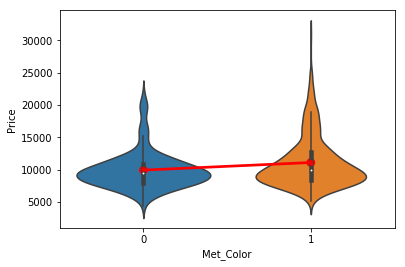

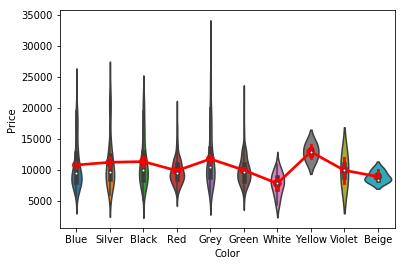

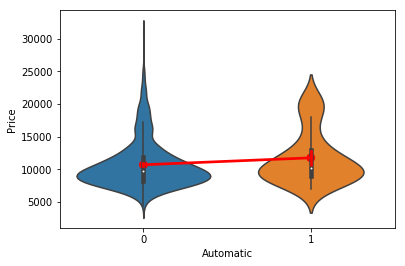

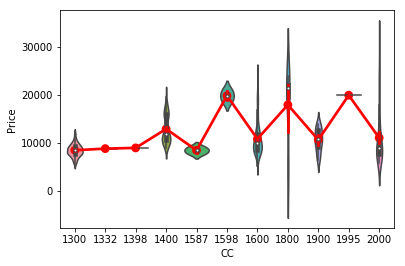

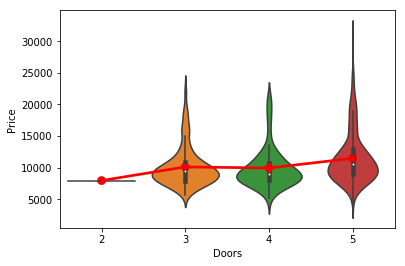

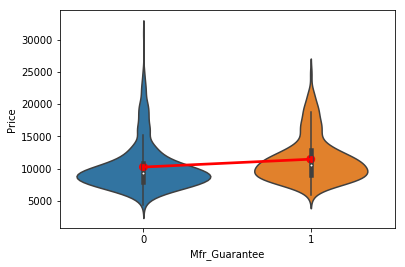

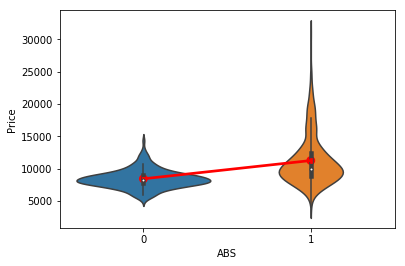

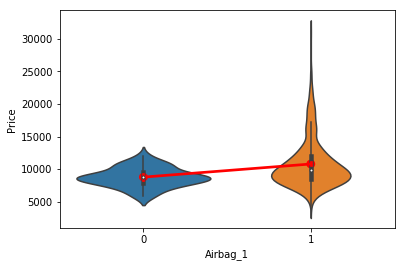

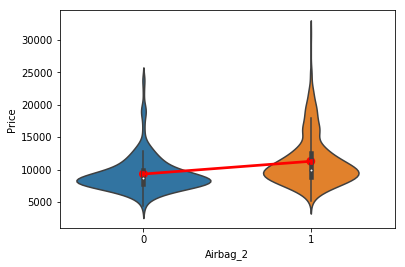

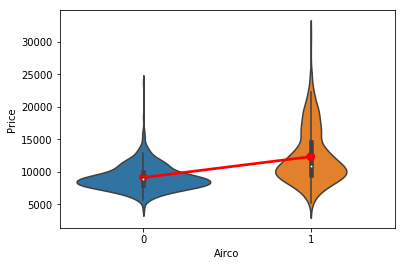

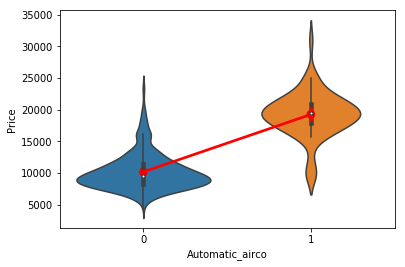

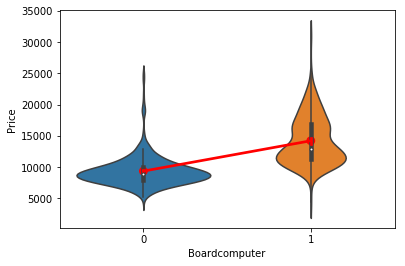

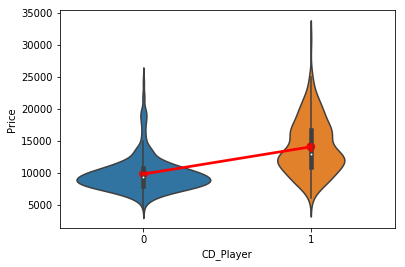

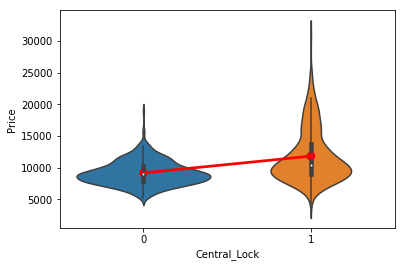

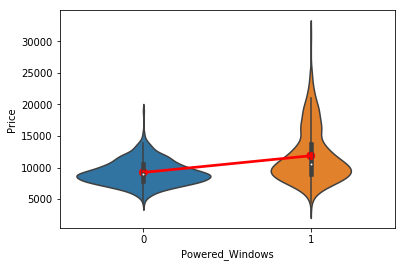

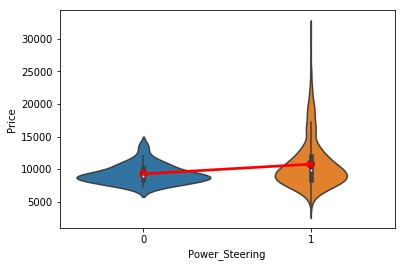

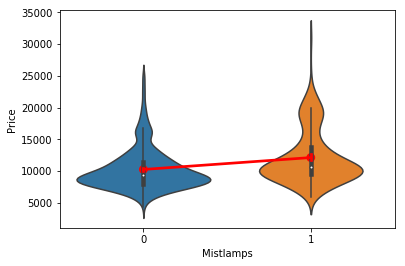

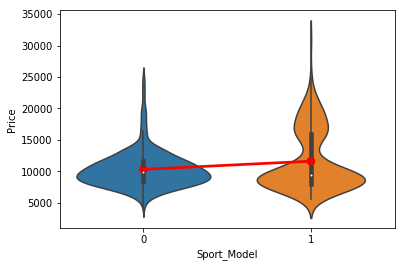

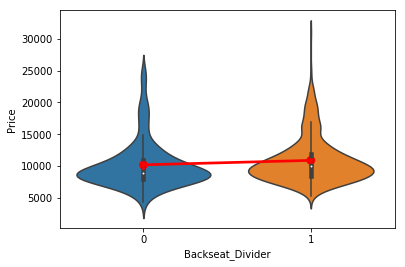

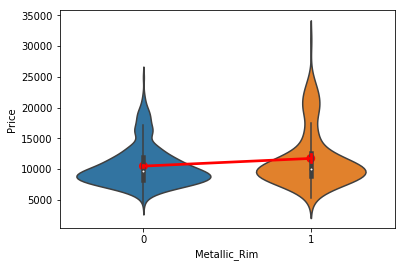

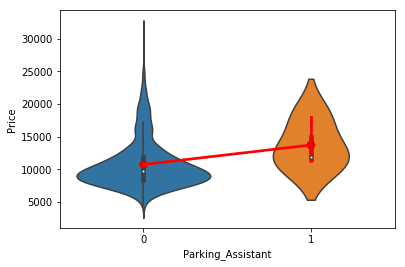

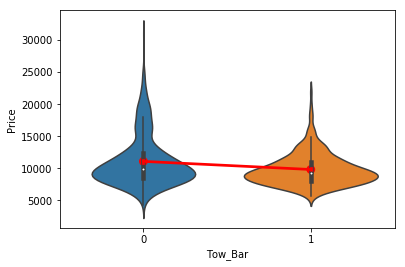

In [72]:
for var in var_cat:
    sns.violinplot(x=var, y="Price", data=df, jitter=True, alpha=.3)
    sns.pointplot(x=var, y="Price", data=df, dodge=True, color='r')
    plt.show()

In [73]:
del dfy['Model']
dfX = pd.concat([df[var_real], df[var_cat]], 1)

In [74]:
df = pd.concat([dfX, dfy], 1)
df = df.set_index('Id')

### OLS 1

In [75]:
var_real

['Age_08_04', 'KM', 'HP', 'Quarterly_Tax', 'Weight', 'Guarantee_Period']

In [76]:
df.columns

Index(['Age_08_04', 'KM', 'HP', 'Quarterly_Tax', 'Weight', 'Guarantee_Period',
       'Met_Color', 'Color', 'Automatic', 'CC', 'Doors', 'Mfr_Guarantee',
       'ABS', 'Airbag_1', 'Airbag_2', 'Airco', 'Automatic_airco',
       'Boardcomputer', 'CD_Player', 'Central_Lock', 'Powered_Windows',
       'Power_Steering', 'Mistlamps', 'Sport_Model', 'Backseat_Divider',
       'Metallic_Rim', 'Parking_Assistant', 'Tow_Bar', 'Price'],
      dtype='object')

In [77]:
dfX_1 = dfX.copy()
df_1 = pd.concat([dfX_1, dfy], 1).set_index('Id')

In [80]:
model_1 = sm.OLS.from_formula("np.log(Price) ~ \
                            scale(Age_08_04) + scale(np.log(KM)) + scale(HP) + scale(Quarterly_Tax) + \
                            scale(np.log(Weight)) + scale(Guarantee_Period) + \
                            C(Met_Color) + C(Color) + C(Automatic)+ C(CC) + C(Doors) + C(Mfr_Guarantee) + \
                            C(ABS) + C(Airbag_1) + C(Airbag_2) + C(Airco) + C(Automatic_airco) + C(Boardcomputer) + \
                            C(CD_Player) + C(Central_Lock) + C(Powered_Windows) + C(Power_Steering) + C(Mistlamps) + \
                            C(Sport_Model) + C(Backseat_Divider) + C(Metallic_Rim) + C(Tow_Bar)", data = df_1)
                              
result_1 = model_1.fit()
print(result_1.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(Price)   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     132.7
Date:                Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                        00:46:32   Log-Likelihood:                 802.47
No. Observations:                1019   AIC:                            -1511.
Df Residuals:                     972   BIC:                            -1279.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

In [81]:
# 귀무가설 채택: 
#    Met_Color, Color, Doors, ABS, Airbag_1, Airbag_2, Airco, Broadcomputer, CD_Plyer 
#    Central_Lock, Powered_Windows, Power_Steering, Mistlamps, Sport_Model, Backseat_Divider, Metallic_Rim, Tow_Bar

#    Quaterly_Tax, Weight, Guarantee_Period 

# 클래스 별로 귀무가설 채택:
#    CC : 데이터 조작 필요

In [82]:
dfX_2 = dfX.copy()
dfX_2.head()

,Age_08_04,KM,HP,Quarterly_Tax,Weight,Guarantee_Period,Met_Color,Color,Automatic,CC,...,CD_Player,Central_Lock,Powered_Windows,Power_Steering,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Parking_Assistant,Tow_Bar
0,23,46986,90,210,1165,3,1,Blue,0,2000,...,0,1,1,1,0,0,1,0,0,0
1,23,72937,90,210,1165,3,1,Silver,0,2000,...,1,1,0,1,0,0,1,0,0,0
2,30,38500,90,210,1170,3,0,Black,0,2000,...,0,1,1,1,1,0,1,0,0,0
3,25,31461,192,100,1185,12,0,Silver,0,1800,...,1,1,1,1,0,0,0,1,0,0
4,25,32189,192,100,1185,3,0,Red,0,1800,...,0,1,1,1,1,1,1,1,0,0


In [83]:
# 데이터 중 CC가 1332, 1398, 1587, 1598, 1900, 2000인 경우는 귀무가설 채택 => 이에 해당하는 CC = 1300 값으로 이동 
# CC가 1300, 1400, 1600, 1800인 경우는 대립가설 채택

In [84]:
def cc_adj(cc):
    if cc == 1332:
        return 1300
    
    elif cc == 1398:
        return 1300
    
    elif cc == 1587:
        return 1300
    
    elif cc == 1598:
        return 1300
    
    elif cc == 1900:
        return 1300
    
    elif cc == 1995:
        return 1300
    
    elif cc == 2000:
        return 1300  
    
    else:
        return cc

In [85]:
dfX_2['CC'] = dfX_2['CC'].apply(cc_adj)

In [86]:
dfX_2.groupby('CC').groups

{1300: Int64Index([   0,    1,    2,   28,   29,   31,   49,   59,   62,   63,
             ...
              997, 1006, 1009, 1011, 1012, 1013, 1014, 1015, 1016, 1017],
            dtype='int64', length=287),
 1400: Int64Index([ 18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
             ...
             406, 407, 408, 412, 413, 415, 416, 417, 419, 420],
            dtype='int64', length=114),
 1600: Int64Index([   8,    9,   10,   11,   12,   13,   14,   15,   16,   17,
             ...
             1000, 1001, 1002, 1003, 1004, 1005, 1007, 1008, 1010, 1018],
            dtype='int64', length=609),
 1800: Int64Index([3, 4, 5, 6, 7, 34, 103, 137, 280], dtype='int64')}

In [87]:
dfX_2.head()

,Age_08_04,KM,HP,Quarterly_Tax,Weight,Guarantee_Period,Met_Color,Color,Automatic,CC,...,CD_Player,Central_Lock,Powered_Windows,Power_Steering,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Parking_Assistant,Tow_Bar
0,23,46986,90,210,1165,3,1,Blue,0,1300,...,0,1,1,1,0,0,1,0,0,0
1,23,72937,90,210,1165,3,1,Silver,0,1300,...,1,1,0,1,0,0,1,0,0,0
2,30,38500,90,210,1170,3,0,Black,0,1300,...,0,1,1,1,1,0,1,0,0,0
3,25,31461,192,100,1185,12,0,Silver,0,1800,...,1,1,1,1,0,0,0,1,0,0
4,25,32189,192,100,1185,3,0,Red,0,1800,...,0,1,1,1,1,1,1,1,0,0


In [88]:
df_2 = pd.concat([dfX_2, dfy], 1)
df_2 = df_2.set_index('Id')

In [89]:
model_2 = sm.OLS.from_formula("np.log(Price) ~ \
                            scale(Age_08_04) + scale(np.log(KM)) + scale(HP) + \
                            C(Automatic) + C(CC) + C(Mfr_Guarantee) + \
                            C(Automatic_airco) \
                            ", data = df_2)
                              
result_2 = model_2.fit()
print(result_2.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(Price)   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     583.2
Date:                Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                        00:46:44   Log-Likelihood:                 720.94
No. Observations:                1019   AIC:                            -1422.
Df Residuals:                    1009   BIC:                            -1373.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [90]:
# scale(np.log(KM))에 대해 귀무가설 채택

In [91]:
dfX_3 = dfX_2.copy()
df_3 = pd.concat([dfX_3, dfy], 1)
df_3.head()

,Age_08_04,KM,HP,Quarterly_Tax,Weight,Guarantee_Period,Met_Color,Color,Automatic,CC,...,Powered_Windows,Power_Steering,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Parking_Assistant,Tow_Bar,Id,Price
0,23,46986,90,210,1165,3,1,Blue,0,1300,...,1,1,0,0,1,0,0,0,1,13500
1,23,72937,90,210,1165,3,1,Silver,0,1300,...,0,1,0,0,1,0,0,0,2,13750
2,30,38500,90,210,1170,3,0,Black,0,1300,...,1,1,1,0,1,0,0,0,5,13750
3,25,31461,192,100,1185,12,0,Silver,0,1800,...,1,1,0,0,0,1,0,0,11,20950
4,25,32189,192,100,1185,3,0,Red,0,1800,...,1,1,1,1,1,1,0,0,13,19600


In [92]:
model_3 = sm.OLS.from_formula("np.log(Price) ~ \
                            scale(Age_08_04) + scale(HP) + \
                            C(Automatic) + C(CC) + C(Mfr_Guarantee) + \
                            C(Automatic_airco) \
                            ", data = df_3)
                              
result_3 = model_3.fit()
print(result_3.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(Price)   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     652.6
Date:                Tue, 24 Oct 2017   Prob (F-statistic):               0.00
Time:                        00:46:45   Log-Likelihood:                 718.29
No. Observations:                1019   AIC:                            -1419.
Df Residuals:                    1010   BIC:                            -1374.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [93]:
## 레버리지와 아웃라이어 찾기

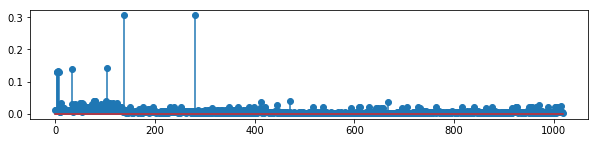

In [94]:
influence = result_3.get_influence()
hat = influence.hat_matrix_diag

plt.figure(figsize=(10, 2))
plt.stem(hat)
plt.show()

In [95]:
# 상수항을 포함한 변수가 총 9개이므로 
print("hat.sum() =", hat.sum())

hat.sum() = 9.0


In [116]:
final = ['Age_08_04', 'HP' , 'Automatic' , 'CC' , 'Mfr_Guarantee' , 'Automatic_airco']
dfX_4 = dfX_3[final]
dfX_4
dfy_1 = dfy['Price']
dfy_1

0       13500
1       13750
2       13750
3       20950
4       19600
5       21500
6       22000
7       22750
8       17950
9       16950
10      15950
11      16950
12      15950
13      16950
14      15950
15      17495
16      15750
17      17950
18      12950
19      15950
20      14950
21      15750
22      15950
23      14950
24      15750
25      13950
26      16750
27      13950
28      16950
29      17950
        ...  
989      7250
990      7450
991      8750
992      9800
993      7500
994      8950
995      8950
996     10500
997      7000
998      8950
999      9250
1000     7900
1001     7950
1002     8750
1003     7500
1004     6950
1005     8750
1006     7750
1007     8450
1008     8150
1009     8500
1010     7600
1011     7950
1012     7750
1013     7950
1014     8950
1015     7500
1016     8500
1017     7250
1018     6950
Name: Price, Length: 1019, dtype: int64

In [158]:
#dfy
cols_final = ['Price','Age_08_04', 'HP' , 'Automatic' , 'CC' , 'Mfr_Guarantee' , 'Automatic_airco']
DF2 = df[cols_final]
DF2.tail()
DF2['leverage'] = list(hat)
DF2.tail()


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,Price,Age_08_04,HP,Automatic,CC,Mfr_Guarantee,Automatic_airco,leverage
Id,,,,,,,,
1434,8950,71,86,1,1300,1,0,0.022922
1438,7500,69,86,0,1300,1,0,0.006300
1440,8500,71,86,0,1300,0,0,0.004258
1441,7250,70,86,0,1300,1,0,0.006375
1442,6950,76,110,0,1600,0,0,0.003688


In [160]:
#레버리지: 실제 종속변수 y값이 예측치 y^hat에 미치는 영향을 나타낸 값. 즉, 예측점을 자기 자신의 위치로 끌어 당기는 정도
print('Leverage')
print(DF2.leverage.describe())
print( '\n')
print('leverage top 10')
print(DF2.sort_values(by = 'leverage', ascending = False).head(10))

Leverage
count    1019.000000
mean        0.008832
std         0.018003
min         0.002636
25%         0.003432
50%         0.004519
75%         0.009814
max         0.306317
Name: leverage, dtype: float64


leverage top 5
     Price  Age_08_04   HP  Automatic    CC  Mfr_Guarantee  Automatic_airco  \
Id                                                                            
193   4350         44   69          0  1800              0                0   
396   4450         56   69          0  1800              0                0   
143  23950         19  192          0  1800              0                0   
54   21950         27  192          0  1800              0                0   
14   21500         31  192          0  1800              1                1   
11   20950         25  192          0  1800              1                1   
13   19600         25  192          0  1800              1                1   
17   22750         30  192          0  1800              0      

In [163]:
''' 
아래 세 가지 항목 설정
1) basic_fomula
2) N
3) df_3 
'''
# fomula
basis_fomula = "np.log(Price) ~ \
                            scale(Age_08_04) + scale(HP) + \
                            C(Automatic) + C(CC) + C(Mfr_Guarantee) + \
                            C(Automatic_airco) \
                            "
                            
# split 개수
N = 10

scores = np.zeros(N)
cv = sklearn.model_selection.KFold(N, shuffle=True)

train_X = df_3
train_y = train_X['Price']

for i, (train_index, test_index) in enumerate(cv.split(train_X)):

    X_train = train_X.loc[train_index]
    y_train = train_y.loc[train_index]
    X_test = train_X.loc[test_index]
    y_test = train_y.loc[test_index]

    result = sm.OLS.from_formula(basis_fomula, data=X_train).fit()
    
    y_pred = result.predict(X_test) 
    
    scores[i] = np.sqrt(mean_squared_error(y_test, np.exp(y_pred)))

scores.mean(), scores.std(), scores 

NameError: name 'sklearn' is not defined

## 선형회귀

In [118]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(dfX_4, dfy_1, random_state=0)

lr = LinearRegression().fit(X_train, y_train)


In [121]:
print('lr.coef_:{}'.format(lr.coef_))
print('lr.intercept_:{}'.format(lr.intercept_))

lr.coef_:[ -145.89293059    63.36254666   848.58362432    -4.21536216   401.51291497
  2975.96902829]
lr.intercept_:18373.577027123432


In [120]:
print('훈련 세트 점수: {:.6f}'.format(lr.score(X_train, y_train)))
print('테스트 세트 점수: {:.6f}'.format(lr.score(X_test, y_test)))

훈련 세트 점수: 0.868891
테스트 세트 점수: 0.830037


## 릿지 회귀

In [123]:
from sklearn.linear_model import Ridge

ridge = Ridge().fit(X_train, y_train)
print('훈련 세트 점수: {:.6f}'.format(ridge.score(X_train, y_train)))
print('테스트 세트 점수: {:.6f}'.format(ridge.score(X_test, y_test)))

훈련 세트 점수: 0.868865
테스트 세트 점수: 0.829805


In [127]:
#alpha 값을 올리면 훈련세트의 성능은 나빠지지만 일반화에는 도움을 준다. default 값은 1.0
ridge10 = Ridge(alpha=10).fit(X_train, y_train)
print('훈련 세트 점수: {:.6f}'.format(ridge10.score(X_train, y_train)))
print('테스트 세트 점수: {:.6f}'.format(ridge10.score(X_test, y_test)))

훈련 세트 점수: 0.867216
테스트 세트 점수: 0.827028


In [125]:
#alpha 값 = 0.1
ridge01 = Ridge(alpha=0.1).fit(X_train, y_train)
print('훈련 세트 점수: {:.6f}'.format(ridge01.score(X_train, y_train)))
print('테스트 세트 점수: {:.6f}'.format(ridge01.score(X_test, y_test)))

훈련 세트 점수: 0.868891
테스트 세트 점수: 0.830015


## 라쏘

In [131]:
from sklearn.linear_model import Lasso

lasso = Lasso().fit(X_train, y_train)
print('훈련 세트 점수: {:.6f}'.format(lasso.score(X_train, y_train)))
print('테스트 세트 점수: {:.6f}'.format(lasso.score(X_test, y_test)))
print('사용한 특성의 수: {}'.format(np.sum(lasso.coef_ !=0)))

훈련 세트 점수: 0.868888
테스트 세트 점수: 0.830104
사용한 특성의 수: 6


In [133]:
#과소적합을 줄일려면 alpha값을 낮춘다. max_iter(반복실행 최대 횟수)늘려야 한다. 
lasso001 = Lasso(alpha=0.01, max_iter=100000).fit(X_train, y_train)
print('훈련 세트 점수: {:.6f}'.format(lasso001.score(X_train, y_train)))
print('테스트 세트 점수: {:.6f}'.format(lasso001.score(X_test, y_test)))
print('사용한 특성의 수: {}'.format(np.sum(lasso001.coef_ !=0)))

훈련 세트 점수: 0.868891
테스트 세트 점수: 0.830038
사용한 특성의 수: 6
